# Задание
Основные цели этого задания:

    - Научиться понижать размерность данных

    - Попрактиковаться в обучении моделей кластеризации

Задача: по замерам акселерометра и гироскопа, произведенным с помощью телефона, находящегося на поясе, научиться отделять различные типы активностей друг от друга.

План решения:

1. Загрузите данные из источника по ссылке. Нам нужен файл X_train.txt (там будет чуть более 7 тысяч наблюдений). Чтобы подгрузить этот файл, можно воспользоваться функцией loadtxt библиотеки numpy.

2. Ознакомьтесь с данными:

    a. выведите количество признаков;

    b. есть ли в данных пропуски;

    c. отличаются ли различные признаки по масштабу.

3. Понизьте размерность данных:

    a. воспользуйтесь методом порога отклонения, чтобы избавиться от наблюдений, вариативность по которым низка. Удалите не более 10 % признаков;

    b. воспользуйтесь методом PCA:

      > приведите признаки к одинаковому масштабу,

      > визуализируйте зависимость степени объяснения дисперсии исходных данных от количества выделяемых главных компонент,

      > определите минимальное необходимое количество главных компонент, при которых объяснение дисперсии исходных данных будет достаточно велико (хотя бы 90 %),

      > выделите первые две главные компоненты и с помощью визуализации убедитесь, что новые признаки позволяют неплохо отделить данные друг от друга.

4. Подберите оптимальное число кластеров:

    a. воспользуйтесь методом локтя, чтобы оценить, как варьируется значение целевой функции кластеризации в зависимости от количества кластеров, на которые мы делим данные;

    b. выберите оптимальное количество кластеров и объясните свой выбор;

    c. повторите визуализацию данных по первым двум главным компонентам, размечая наблюдения каждого кластера своим цветом.

5. Оцените качество кластеризации:

    a. подгрузите реальные метки наблюдений из файла y_train.txt, а также их значения из файла activity_labels.txt;

    b. определите, насколько логична полученная кластеризация. Можно, например, сформировать сводную таблицу, где в строках будут реальные активности, а в столбцах — лейблы, полученные согласно кластеризации;

    c. сделайте выводы, опишите, почему те или иные виды активности могли объединиться в один кластер, а другие отделиться от них.

In [1]:
# Импорт нужных библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import VarianceThreshold
from tqdm import tqdm
from pyod.models.knn import KNN 

<div class="alert alert-info">

1. Загрузите данные из источника по ссылке. Нам нужен файл X_train.txt (там будет чуть более 7 тысяч наблюдений). Чтобы подгрузить этот файл, можно воспользоваться функцией loadtxt библиотеки numpy.

Загружаем данные 

In [2]:
df = np.loadtxt('X_train.txt', dtype='float64')

In [3]:
df

array([[ 0.28858451, -0.02029417, -0.13290514, ..., -0.84124676,
         0.17994061, -0.05862692],
       [ 0.27841883, -0.01641057, -0.12352019, ..., -0.8447876 ,
         0.18028889, -0.05431672],
       [ 0.27965306, -0.01946716, -0.11346169, ..., -0.84893347,
         0.18063731, -0.04911782],
       ...,
       [ 0.27338737, -0.01701062, -0.04502183, ..., -0.77913261,
         0.24914484,  0.04081119],
       [ 0.28965416, -0.01884304, -0.15828059, ..., -0.78518142,
         0.24643223,  0.02533948],
       [ 0.35150347, -0.01242312, -0.20386717, ..., -0.78326693,
         0.24680852,  0.03669484]])

In [4]:
df.shape 

(7352, 561)

Смотрим на размеры и видим, что данные имеют 7352 строки и 561 колонки

In [5]:
count_columns = (f'col_{i}' for i in range(561)) 
# создаем кортеж, который послужит нам нумерацией колонок в датафрейме(Кортеж, потому что он легче списка)

In [6]:
df = pd.DataFrame(df, columns=count_columns) # Переводим данные в датафрейм

In [7]:
df.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_551,col_552,col_553,col_554,col_555,col_556,col_557,col_558,col_559,col_560
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


<div class="alert alert-info">

2. Ознакомьтесь с данными:

    a. выведите количество признаков;

    b. есть ли в данных пропуски;

    c. отличаются ли различные признаки по масштабу.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, col_0 to col_560
dtypes: float64(561)
memory usage: 31.5 MB


Первичный просмотр данных, дал информацию, что пропусков в данных нет, посмотрим более подробно. Все данные типа float

In [9]:
df.isna().sum()

col_0      0
col_1      0
col_2      0
col_3      0
col_4      0
          ..
col_556    0
col_557    0
col_558    0
col_559    0
col_560    0
Length: 561, dtype: int64

Пропусков нет

In [10]:
# a. Выведите количество признаков
num_features = len(df.columns)
print(f"Количество признаков: {num_features}")
# b. Как и было сказано пропусков нет

Количество признаков: 561


In [11]:
# Проверьте различные признаки по масштабу
feature_scales = df.describe().loc[['std', 'mean']]
if (feature_scales.loc['std'] > 1.0).any():
    print("Различные признаки отличаются по масштабу")
else:
    print("Различные признаки не отличаются по масштабу")

Различные признаки не отличаются по масштабу


> a. Количество признаков 561 штука

> b. Пропусков нет
    
> с. Признаки не отличаются по масштабу

<div class="alert alert-info">

3. Понизьте размерность данных:

    a. воспользуйтесь методом порога отклонения, чтобы избавиться от наблюдений, вариативность по которым низка. Удалите не более 10 % признаков;

    b. воспользуйтесь методом PCA:

      > приведите признаки к одинаковому масштабу,

      > визуализируйте зависимость степени объяснения дисперсии исходных данных от количества выделяемых главных компонент,

      > определите минимальное необходимое количество главных компонент, при которых объяснение дисперсии исходных данных будет достаточно велико (хотя бы 90 %),

      > выделите первые две главные компоненты и с помощью визуализации убедитесь, что новые признаки позволяют неплохо отделить данные друг от друга.

In [12]:
var = VarianceThreshold(threshold=0.01) # "Удалите не более 10 % признаков"
df2 = var.fit_transform(df)
# Получение размерности массива данных
shape = df2.shape
num_rows = shape[0]
num_cols = shape[1]  # количество столбцов

print("Количество строк:", num_rows)
print("Количество столбцов:", num_cols)
# df3 = pd.DataFrame(df2, columns=(f'col_{i}' for i in range(num_cols)) # Переводим данные в датафрейм

Количество строк: 7352
Количество столбцов: 524


По новой создаем датафрейм, только уже из 524 колонок

In [13]:
# a. Удалите признаки с низкой вариативностью
df3 = pd.DataFrame(df, columns=(f'col_{i}' for i in range(524))) # Переводим данные в датафрейм
print("Количество признаков после удаления:", len(df3.columns))

Количество признаков после удаления: 524


In [14]:
# b. Приведем признаки к одинаковому масштабу
scaler = StandardScaler()
scaler.fit(df3)
scaled_data = scaler.transform(df3)

In [15]:
# Выполним метод главных компонент
pca = PCA()
pca.fit(scaled_data)

PCA()

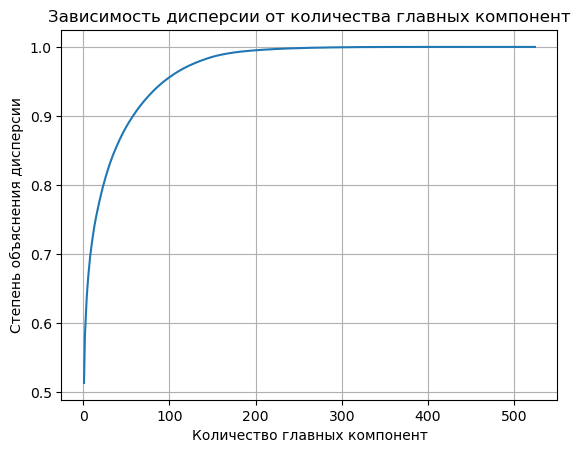

In [16]:
# Визуализируем зависимость степени объяснения дисперсии исходных данных от количества главных компонент
explained_var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(explained_var) + 1), explained_var)
plt.xlabel('Количество главных компонент')
plt.ylabel('Степень объяснения дисперсии')
plt.title('Зависимость дисперсии от количества главных компонент')
plt.grid()
plt.show()

In [17]:
# Определим минимальное необходимое количество главных компонент
num_components = np.argmax(explained_var >= 0.9) + 1
print("Минимальное необходимое количество главных компонент:", num_components)

Минимальное необходимое количество главных компонент: 58


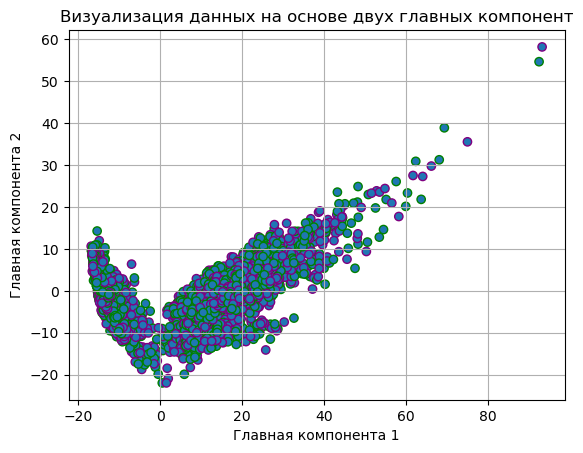

In [18]:
# Выделим первые две главные компоненты и визуализируем их
pca_2d = PCA(n_components=2)
new_data = pca_2d.fit_transform(scaled_data)
plt.scatter(new_data[:, 0], new_data[:, 1], edgecolors=['green', 'purple'])
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.title('Визуализация данных на основе двух главных компонент')
plt.grid()
plt.show()

<div class="alert alert-info">

4. Подберите оптимальное число кластеров:

    a. воспользуйтесь методом локтя, чтобы оценить, как варьируется значение целевой функции кластеризации в зависимости от количества кластеров, на которые мы делим данные;

    b. выберите оптимальное количество кластеров и объясните свой выбор;

    c. повторите визуализацию данных по первым двум главным компонентам, размечая наблюдения каждого кластера своим цветом.

  0%|                                                                                           | 0/57 [00:00<?, ?it/s]C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  2%|█▍                                                                                 | 1/57 [00:01<01:19,  1.43s/it]C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  4%|██▉                                                                                | 2/57 [00:02<01:17,  1.42s/it]C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value

 81%|██████████████████████████████████████████████████████████████████▏               | 46/57 [03:51<01:18,  7.15s/it]C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 82%|███████████████████████████████████████████████████████████████████▌              | 47/57 [03:57<01:09,  6.92s/it]C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 84%|█████████████████████████████████████████████████████████████████████             | 48/57 [04:05<01:03,  7.07s/it]C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value

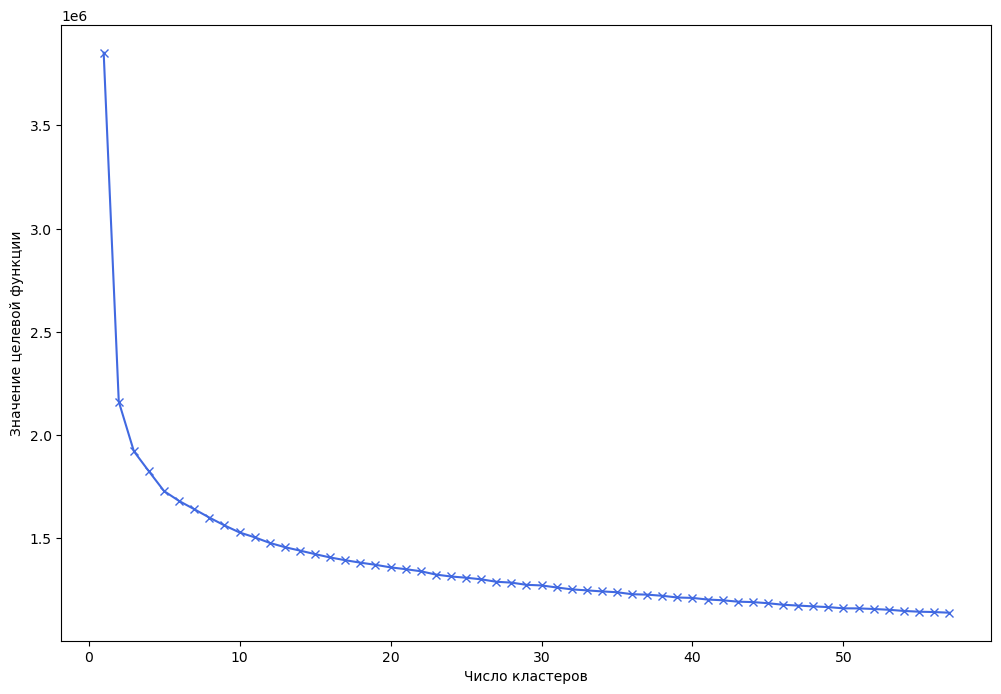

In [19]:
distortion = []
K = range(1, num_components)
for k in tqdm(K):
    model = KMeans(n_clusters=k, random_state=4)
    model.fit(scaled_data)
    distortion.append(model.inertia_) 

plt.figure(figsize=(12, 8))
plt.plot(K, distortion, c='royalblue', marker='x')
plt.xlabel('Число кластеров')
plt.ylabel('Значение целевой функции')
plt.show()

Выбор падает на 2 кластеров, тк дальше большее их количетсов уже не так сильно влияет на значение функции

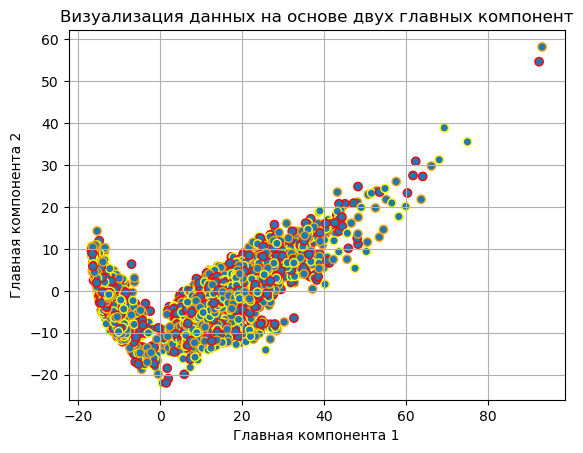

In [20]:
# Выделим первые две главные компоненты и визуализируем их
pca_2d = PCA(n_components=2)
new_data = pca_2d.fit_transform(scaled_data)
plt.scatter(new_data[:, 0], new_data[:, 1], edgecolors=['yellow', 'red', 'orange'])
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.title('Визуализация данных на основе двух главных компонент')
plt.grid()
plt.show()

Заметны выбросы в верхнем правом углу). 

<div class="alert alert-info">

5. Оцените качество кластеризации:

    a. подгрузите реальные метки наблюдений из файла y_train.txt, а также их значения из файла activity_labels.txt;

    b. определите, насколько логична полученная кластеризация. Можно, например, сформировать сводную таблицу, где в строках будут реальные активности, а в столбцах — лейблы, полученные согласно кластеризации;

    c. сделайте выводы, опишите, почему те или иные виды активности могли объединиться в один кластер, а другие отделиться от них.

In [21]:
# Загрузка меток наблюдений
y_train = np.loadtxt('y_train.txt')

In [22]:
# Загрузка значений меток
activity_labels = pd.read_csv('activity_labels.txt', sep=' ', header=None)

In [23]:
# Вывод меток наблюдений
y_train = pd.Series(y_train)
print("Метки наблюдений:")
y_train

Метки наблюдений:


0       5.0
1       5.0
2       5.0
3       5.0
4       5.0
       ... 
7347    2.0
7348    2.0
7349    2.0
7350    2.0
7351    2.0
Length: 7352, dtype: float64

In [24]:
# Вывод значений меток
print("Значения меток:")
print(activity_labels)

Значения меток:
   0                   1
0  1             WALKING
1  2    WALKING_UPSTAIRS
2  3  WALKING_DOWNSTAIRS
3  4             SITTING
4  5            STANDING
5  6              LAYING


In [25]:
# Создание объекта KMeans
kmeans = KMeans(n_clusters=2)

# Кластеризация данных
kmeans.fit(scaled_data)

# Получение центроидов каждого кластера
centroids = kmeans.cluster_centers_

# Получение принадлежности кластера для каждой точки данных
cluster_label = kmeans.labels_

C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [26]:
# Вывод лейблов каждой точки данных
cluster_label = list(cluster_label)
cluster_labels = pd.Series(cluster_label)
table = pd.crosstab(y_train, cluster_labels, rownames=['Реальные активности'], colnames=['Лейблы'])

# Вывод сводной таблицы
print("Сводная таблица:")
print(table)

Сводная таблица:
Лейблы                  0     1
Реальные активности            
1.0                  1226     0
2.0                  1065     8
3.0                   986     0
4.0                     1  1285
5.0                     0  1374
6.0                    11  1396


**Вывод:** 
   > Мы видим в 2 лейбл единственный, в котором у нас сталкиваются все значения, пускай и сильный разброс между 1.0-3.0 и 4.0-6.0 (в первом случае их много, во втором раз, два и обчёлся)
   
   > В случае 0-ого и 1-ого кластера ситуация тоже непростая: в нулевом все значения 1.0-3.0, хоть не так много, а в первом лейбле все с 4.0-6.0, причем довольно много

Могу предположить, что такой расклад со вторым кластером связан с тем, что он обладает обобщающим своиством, объединяя свойства 0-го и 1-го кластера.
Как например, если бы 0-ой и 1-ый кластер(лейбл) были персиком и сливой, а 2-ой был бы нектарином.